In [1]:
using Pkg; Pkg.activate()

using DataFrames, CSV
using Distributions, Random
using LinearAlgebra
using Plots

using Revise
using CarbonNetworks


In [9]:
#Parameters
DATAPATH = "/Users/apple/Documents/REU/carbon_data"
num_generators = 1
pmax_increase = 100
train_size = 1
test_size = 1
# Algorithm parameters
step_size = 20
max_iter = 500
batch_size = 8
test_batch_size = 1
gradient_scale = 1e-3

0.001

50-100-150-200-250-300-350-400-450-500-119.184102 seconds (81.19 M allocations: 45.191 GiB, 4.83% gc time)
Completed 500 iterations.
minimum(norm.(grad_hist)) = 16.406774439315154


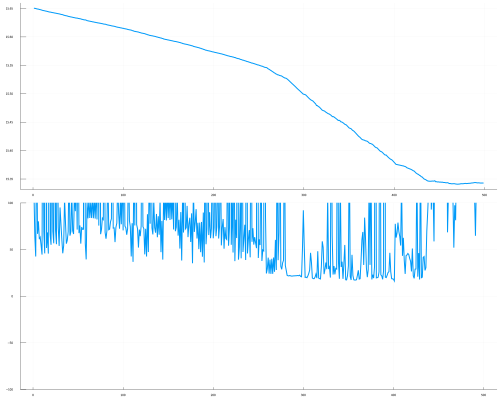

In [10]:
#Load Data
A, B, gmax, pmax, f, G, nodes = parse_network_data(DATAPATH; num_generators)
n, m = size(A)
n, l = size(B)
normalization = mean(gmax)
gmax /= normalization
pmax /= normalization
pmax .+= pmax_increase
gen_labels, M = create_generation_map(nodes; num_generators)

file_names = joinpath.(joinpath(DATAPATH, "TRAIN"), readdir(joinpath(DATAPATH, "TRAIN")))

# Load Cases
cases = []
for file in file_names   
    d, g, case = load_case(file, gen_labels, B, nodes)
    d = d/normalization
    g = g/normalization
    push!(cases, (d=d, g=g, case=case))
end

train_cases = cases[1:train_size]
test_cases = cases[100:100+test_size-1];

# Initialize
# Seeds that seem to work: 706
seed = rand(1:1_000)
Random.seed!(seed)
# Initialize estimated costs
global f̂q = max.(1.0, 10 .+ randn(l)) 
global f̂l = max.(1.0, 10 .+ randn(l)) 
mean_est_cost = mean(f̂q)
train_loss_hist = []
test_loss_hist = []
grad_hist = []

# Fit
@time for iter in 1:max_iter
    if mod(iter, 50) == 0
        print("$(iter)-")
    end
    # Evaluate loss and gradient
    sample = rand(1:length(train_cases), batch_size)
    L, dfq, dfl = stochastic_loss_and_grad(sample, train_cases, f̂q, f̂l, M, pmax, gmax, A, B)
    
    push!(train_loss_hist, L)
    push!(grad_hist, dfq)
    
    # Compute test loss
    # sample = rand(1:length(test_cases), test_batch_size)
    # L_test, _ = stochastic_loss_and_grad(f̂, B, test_cases, pmax, gmax, A, sample)
    # push!(test_loss_hist, L_test)
    
    # Take projected gradient step
    # df += (1/n) * f̂
    η = gradient_scale * min(norm(dfq), step_size)
    global f̂q = max.(f̂q - η*(dfq/norm(dfq)), 1)
    
    η = gradient_scale * min(norm(dfl), step_size)
    global f̂l = max.(f̂l - η*(dfl/norm(dfl)), 1)
end
min_loss = minimum(train_loss_hist)
println("Completed $(max_iter) iterations.")

# Plot 
theme(:default, lw=4, label=nothing)
best_so_far(x) = [minimum(x[1:k]) for k in 1:length(x)]
rolling_avg(x, lag) = [mean(x[i:i+lag-1]) for i in 1:(length(x)-lag)]
@show minimum(norm.(grad_hist))

Δhist = [dfq[100] for dfq in grad_hist]
Δhist = norm.(grad_hist)

plt = plot(
    plot(rolling_avg(train_loss_hist, 1), ylabel="train"),
    plot(Δhist, ylabel="grad hist", ylim=(-100, 100)),
    layout=(2, 1),
    size = (2000,1600)
)